In [21]:
import random
import os
import re
import sys
import copy
import datetime
import traceback
import heapq
sys.path.append('../..')
sys.path.append('..')
from tqdm import tqdm
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset

import youtokentome as yttm

from modules.simple_nn_transformer import init_random_seed, fast_clean_text, save_texts_to_file, ensure_length, \
LanguageModelDataset, make_target_dependency_mask, make_positional_encoding, LanguageModel, lm_cross_entropy, \
lr_scheduler, BatchFirstTransformerEncoder, train_eval_loop, get_params_number, BeamGenerator,  \
copy_data_to_device

In [17]:
DIR_DATA = '../data/killplsme'
DIR_MODELS = '../models/killplsme'
DF = 'killplsme_20211004-194643.csv'
os.makedirs(os.path.join(DIR_DATA), exist_ok=True)
os.makedirs(os.path.join(DIR_MODELS), exist_ok=True)

In [8]:
df = pd.read_csv(os.path.join(DIR_DATA, DF), lineterminator='\n')

In [9]:
df.head()

,id,date,tags,likes,text
0,11,"16 марта 2009, 13:56",техника,-11312,\tВызвал сантехника прочистить раковину на кух...
1,10,"16 марта 2009, 13:56",отношения,26614,"\tЯ почти год встречаюсь с мужчиной, три месяц..."
2,9,"16 марта 2009, 13:56",отношения,13795,"\tЗадержался на пьянке по поводу праздника, по..."
3,8,"16 марта 2009, 13:55","работа , секс , друзья , отношения",126862,18+
4,7,"16 марта 2009, 13:55","семья , отношения",77501,"\tПока моя девушка пошла на часок к маме, зале..."


In [11]:
full_text = ' '.join(df.text.values)
full_text = fast_clean_text(full_text)
all_chunks = [full_text[start:start+200] for start in range(0, len(full_text), 200//2)]
len(all_chunks)

161467

In [12]:
print(all_chunks[11])

у про то как она скучает какая она горячая и подобное Ну фигня думаю он Алекс я Алексей она и раньше не туда отправляла часто смеялись И тут ей приходит смс от брата жду тебя уже в кровати моя Пристре


In [13]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

del all_chunks

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 113026
Размер валидационной выборки 48441


In [18]:
BPE_MODEL_FILENAME = os.path.join(DIR_MODELS, 'bpe_model.yttm')

In [19]:
TRAIN_TEXTS_FILENAME = os.path.join(DIR_DATA, 'bpe_train.txt')
save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)

In [18]:
%%time
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME);

CPU times: user 2.98 s, sys: 186 ms, total: 3.17 s
Wall time: 663 ms


In [10]:
%%time
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

CPU times: user 613 µs, sys: 208 µs, total: 821 µs
Wall time: 1.01 ms


In [20]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е т н и с л р в м д у к п я ь б ч з г ы ж й ш ю х П ц М щ э Н В К С Я О ф И А Д У Т Р Е З Б ъ Ч Г Ж Л Э Х Ш Ф Ь Ц Й Ы Ю Щ Ъ ▁н ▁п ▁с ▁в то ▁м ▁о ла ▁и ▁д ен ра ▁по ▁не ▁к ть ро но го ли ▁на ст ▁б ет ▁ч ре ▁у за ва ▁т ко на ло ка ся ни ри ▁е да ль ▁что ▁за ▁я во сь ▁ра ем ру та те ди не хо ле ▁мо ▁ж ▁то ▁ко ма ер ак ти ▁П бо ▁от ▁до ▁а еня ▁вс ▁про ны де ▁меня ▁бы ▁э ча ▁но ки ▁го ▁л ▁Н мо чи же ми ▁ни ей ени ви ▁со му ▁хо ▁при ▁все ▁В ▁ма ▁это ень ▁вы до ▁об ▁К ну ▁во ▁М ку уж ста си ше ере ▁С ▁Я ▁з сто ▁мне МП ве ля ▁де ▁жи че ши ▁как ▁ро ▁ре лась ▁да ▁О гда ▁бо га ▁рабо ▁раз ▁он би ▁се ду ры ться ▁из ня ву ▁И па лу ме ▁она пи ▁г ты ▁па ной жа ▁дру по ▁А ▁под ту ▁По сть ▁ка ▁ме сти ▁так гу ▁лю лся лю ▁муж ги ▁его лько жи каза ▁те льно ▁Д ще ез ▁сво ха ется ▁та ▁ста ▁КМП ▁са ▁У ют кой ▁ве бы ▁лет ря ▁кото лись со ша ▁си ▁роди сле вы ци ▁бу ды ▁уже ▁пере ▁зна ный щи са ▁боль ▁Т ▁ку вать ▁ли се ▁Но ▁мы ▁день бе ▁пре мен лось ерь ная ▁же вно ▁ПМП нима чу пе ▁

In [21]:
print(tokenizer.encode(train_texts[:2]))

[[4, 247, 555, 212, 137, 726, 297, 256, 562, 164, 373, 169, 100, 116, 242, 88, 322, 116, 11, 469, 70, 120, 14, 150, 104, 30, 766, 216, 72, 280, 104, 330, 72, 194, 6, 298, 758, 72, 611, 28, 120, 775, 152, 101, 15, 158, 410, 928, 163, 80, 151, 82, 409, 257, 806, 941, 138, 25, 86, 579, 14, 617, 356, 144, 8, 321, 345, 711, 77, 162, 74, 128, 26, 70, 13], [89, 78, 128, 949, 450, 250, 13, 21, 111, 83, 116, 130, 76, 394, 915, 408, 218, 455, 593, 818, 337, 102, 111, 133, 14, 122, 18, 195, 89, 126, 117, 77, 82, 110, 15, 418, 76, 192, 220, 108, 33, 26, 501, 239, 81, 213, 88, 72, 74, 20, 265, 116, 22, 174, 163, 944, 78, 211, 31, 310, 6, 76, 9, 25, 89, 95, 243, 672, 15, 77, 71, 94, 16, 642, 220, 108, 304, 31, 311, 170, 17, 144, 877, 157, 220, 104]]


In [22]:
train_texts[:2]

['ще надо И вс таки ПМП У моей мамы обнаружили вирусную пневмонию Сейчас она в больнице в реанимации в крайне тяжелом состоянии Врачи не делают никаких прогнозов хотя лечат ее очень хорошо и все меры пр',
 'на держала сухарь я крутила ручку была громкая музыка я отвлеклась на кота и не заметила как пальцы подруги попали в мясорубку В итоге двух фаланг на указательном и среднем пальцах нет Куча крови пани']

In [23]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

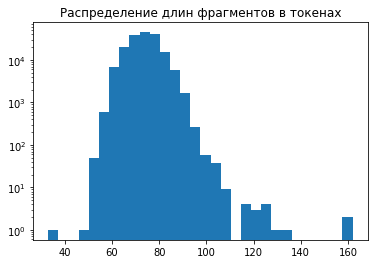

In [24]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

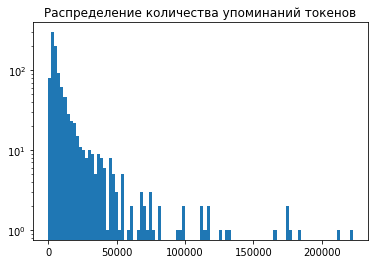

In [25]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [26]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


In [27]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(train_token_ids,
                                     chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids,
                                    chunk_length=CHUNK_LENGTH)

In [28]:
train_dataset[0]

(array([  2,   4, 247, 555, 212, 137, 726, 297, 256, 562, 164, 373, 169,
        100, 116, 242,  88, 322, 116,  11, 469,  70, 120,  14, 150, 104,
         30, 766, 216,  72, 280, 104, 330,  72, 194,   6, 298, 758,  72,
        611,  28, 120, 775, 152, 101,  15, 158, 410, 928, 163,  80, 151,
         82, 409, 257, 806, 941, 138,  25,  86, 579,  14, 617, 356, 144,
          8, 321, 345, 711,  77, 162,  74, 128,  26,  70,  13,   0,   0,
          0,   0]),
 array([  4, 247, 555, 212, 137, 726, 297, 256, 562, 164, 373, 169, 100,
        116, 242,  88, 322, 116,  11, 469,  70, 120,  14, 150, 104,  30,
        766, 216,  72, 280, 104, 330,  72, 194,   6, 298, 758,  72, 611,
         28, 120, 775, 152, 101,  15, 158, 410, 928, 163,  80, 151,  82,
        409, 257, 806, 941, 138,  25,  86, 579,  14, 617, 356, 144,   8,
        321, 345, 711,  77, 162,  74, 128,  26,  70,  13,   3,   0,   0,
          0,   0]))

In [29]:
make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256,
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=256,
                                           nhead=16,
                                           dim_feedforward=512,
                                           dropout=0.1),
                                       num_layers=3),
                                   emb_dropout=0.1)
print('Количество параметров', get_params_number(torch_transf_model))

Количество параметров 2094312


In [31]:
(best_val_loss,
 best_torch_transf_model) = train_eval_loop(torch_transf_model,
                                            train_dataset,
                                            test_dataset,
                                            lm_cross_entropy,
                                            lr=2e-3,
                                            epoch_n=100,
                                            batch_size=64,
                                            device='cuda',
                                            early_stopping_patience=5,
                                            max_batches_per_epoch_train=1000,
                                            max_batches_per_epoch_val=1000,
                                            lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 1001 итераций, 40.54 сек
Среднее значение функции потерь на обучении 5.897737604992969
Среднее значение функции потерь на валидации 5.543127995032768
Новая лучшая модель!

Эпоха 1
Эпоха: 1001 итераций, 41.18 сек
Среднее значение функции потерь на обучении 5.406984911336528
Среднее значение функции потерь на валидации 5.113923025178861
Новая лучшая модель!

Эпоха 2
Эпоха: 1001 итераций, 40.39 сек
Среднее значение функции потерь на обучении 5.045798923823979
Среднее значение функции потерь на валидации 4.778707005046345
Новая лучшая модель!

Эпоха 3
Эпоха: 1001 итераций, 40.82 сек
Среднее значение функции потерь на обучении 4.836383343695641
Среднее значение функции потерь на валидации 4.626891889772215
Новая лучшая модель!

Эпоха 4
Эпоха: 1001 итераций, 41.08 сек
Среднее значение функции потерь на обучении 4.728045800349095
Среднее значение функции потерь на валидации 4.536378777110493
Новая лучшая модель!

Эпоха 5
Эпоха: 1001 итераций, 40.88 сек
Среднее значение функции 

Среднее значение функции потерь на валидации 3.8062607968127455
Новая лучшая модель!

Эпоха 44
Эпоха: 1001 итераций, 45.06 сек
Среднее значение функции потерь на обучении 4.023835272936673
Среднее значение функции потерь на валидации 3.8116765539129296

Эпоха 45
Эпоха: 1001 итераций, 43.85 сек
Среднее значение функции потерь на обучении 4.021441928871147
Среднее значение функции потерь на валидации 3.8036131172866137
Новая лучшая модель!

Эпоха 46
Эпоха: 1001 итераций, 44.04 сек
Среднее значение функции потерь на обучении 4.022336827648746
Среднее значение функции потерь на валидации 3.804681353516631

Эпоха 47
Эпоха: 1001 итераций, 44.69 сек
Среднее значение функции потерь на обучении 4.017074279375486
Среднее значение функции потерь на валидации 3.7964081557004246
Новая лучшая модель!

Эпоха 48
Эпоха: 1001 итераций, 43.78 сек
Среднее значение функции потерь на обучении 4.015108776616526
Среднее значение функции потерь на валидации 3.7935189133757476
Новая лучшая модель!

Эпоха 49
Эпо

Среднее значение функции потерь на валидации 3.735504962109424
Новая лучшая модель!

Эпоха 90
Эпоха: 1001 итераций, 42.23 сек
Среднее значение функции потерь на обучении 3.9633458956376417
Среднее значение функции потерь на валидации 3.734101541273363
Новая лучшая модель!

Эпоха 91
Эпоха: 1001 итераций, 41.70 сек
Среднее значение функции потерь на обучении 3.9619698660237925
Среднее значение функции потерь на валидации 3.7380327702044966

Эпоха 92
Эпоха: 1001 итераций, 42.11 сек
Среднее значение функции потерь на обучении 3.961494438417189
Среднее значение функции потерь на валидации 3.7354054339043983

Эпоха 93
Эпоха: 1001 итераций, 42.23 сек
Среднее значение функции потерь на обучении 3.961917371302099
Среднее значение функции потерь на валидации 3.7330064194781203
Новая лучшая модель!

Эпоха 94
Эпоха: 1001 итераций, 41.86 сек
Среднее значение функции потерь на обучении 3.9620905844243492
Среднее значение функции потерь на валидации 3.7345398105941454

Эпоха 95
Эпоха: 1001 итераций, 

In [32]:
torch.save(best_torch_transf_model.state_dict(), os.path.join(DIR_MODELS,'torch_transf_best.pth'))

In [12]:
torch_transf_model.load_state_dict(torch.load(os.path.join(DIR_MODELS,'torch_transf_best.pth')))

<All keys matched successfully>

In [13]:
beam_generator = BeamGenerator(torch_transf_model, tokenizer)

In [17]:
beam_generator(
    'КМП',
    beamsize=5,
)

[(3.0440873503684998, 'КМП Живу<EOS>'),
 (4.4340616663297014, 'КМП Живем вместе с мужем вместе<EOS>'),
 (5.5119934492333345, 'КМП Живем вместе с мужем с мужем вместе<EOS>'),
 (5.953215771675442, 'КМП Живем вместе с мужем в мага<EOS>'),
 (6.109270653029032, 'КМП Живем с парнем с парнем вместе вместе вместе<EOS>')]